In [182]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re
import math
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict
from IPython.core.display import display, HTML
import pickle
#display(HTML(my_html))     # make sure Jupyter knows to display it as HTML

In [2]:
dirs = {'fassbinder': 'https://www.imdb.com/name/nm0001202/', \
        'godard':'https://www.imdb.com/name/nm0000419/', \
        'hitchcock': 'https://www.imdb.com/name/nm0000033', \
        'speilberg': 'https://www.imdb.com/name/nm0000229', \
        'kurosawa': 'https://www.imdb.com/name/nm0000041/', \
        'bergman': 'https://www.imdb.com/name/nm0000005/', \
        'allen': 'https://www.imdb.com/name/nm0000095',\
        'herzog': 'https://www.imdb.com/name/nm0001348/'}
        # scorcese

dirs_box_office = {'hitchcock':'https://www.the-numbers.com/person/66230401-Alfred-Hitchcock#tab=technical'}

In [3]:
director = 'hitchcock'

dirs_page = dirs[director]
url = dirs_page
response = requests.get(url)
print( response.status_code )
page = response.text
soup = BeautifulSoup(page, "lxml")
#need to distinguish 'filmo-head-director' from 'assistant_director' etc.
head_director_soup = soup.find('div', id='filmo-head-director')
head_director_section_soup= head_director_soup.find_next_sibling('div', class_='filmo-category-section')
films = head_director_section_soup.find_all('div', class_=re.compile('filmo-row'), id=re.compile("director"))
#films = soup.find_all('div', class_=re.compile('filmo-row'), id=re.compile("director"))

200


* Clean the datapoints below
* Ensure they are available or handled for each film's page
* Convert into numeric datatypes
* Populate a list of dictionaries with these 
* Within the loop that goes through every flick, populate the list of dictionaries with these
* Do one-hot-encoding on categorical variables
* Train and test the linear regression model

In [4]:
def is_tv_series( the_film_soup ):
    try:
        parenthesis = the_film_soup.find('a').next
        try:
            if 'TV ' in parenthesis.next:
                return True
            else:
                return False
        except:
            return False
    except:
        return False

In [5]:
def is_documentary( the_film_soup ):
    try:
        parenthesis = the_film_soup.find('a').next
        #print(parenthesis)
        try:
            if 'documentary' in parenthesis.next.lower():
                return 1
            else:
                return 0
        except:
            return 0
    except:
        return 0

In [6]:
def parse_crew_data(the_crew_soup):
    crew_data = {}
    try: 
        #print( the_crew_soup.find('h4', id='cinematographer').next_sibling )
        crew_data['cinematographer'] = the_crew_soup.find('h4', id='cinematographer').find_next_sibling('table', class_='simpleTable').find('a').text.strip()
    except: 
        crew_data['cinematographer'] = ''
    return (crew_data)

In [7]:
def parse_cast_data(the_film_soup):
    try:
        cast_table = the_film_soup.find('table', class_='cast_list').find_all('td', class_='primary_photo')
        cast_list = [(row.find_next_sibling().text.strip(), 1) for row in cast_table ]
        #cast_dict= defaultdict(cast_list)
        #cast_dict.setdefault(1)
        cast_dict = dict(cast_list)
        #print(cast_dict)
        return(cast_dict)
        #return(  the_film_soup.find('table', class_='cast_list').find_all('a', class_='primary_photo').find_next_sibling().text )
        
 #       the_film_soup.find('table', class_='cast_list').find_all('a', class_=re.compile('filmo-row'), id=re.compile("director"))
  #  return the_film_soup.find('table', class_='cast_list').find('a')
    except:
        return dict()

NameError: name 'cast_dict' is not defined

In [8]:
# TEST AREA
test_url = dirs['fassbinder']
test_response = requests.get(test_url)
test_page = test_response.text
test_soup = BeautifulSoup(test_page, "lxml")
test_row = test_soup.find(id='director-tt0080196')
#print(test_row)

print( test_url)
test_film_url = 'https://www.imdb.com/title/tt0084654/'
test_film_response = requests.get(test_film_url)
if(test_film_response.status_code < 400):
    test_film_page = test_film_response.text
    test_film_soup = BeautifulSoup(test_film_page, "lxml")

#print( parse_cast_data( test_film_soup ))
parse_cast_data( test_film_soup )

https://www.imdb.com/name/nm0001202/


{'Rosel Zech': 1,
 'Hilmar Thate': 1,
 'Cornelia Froboess': 1,
 'Annemarie Düringer': 1,
 'Doris Schade': 1,
 'Erik Schumann': 1,
 'Peter Berling': 1,
 'Günther Kaufmann': 1,
 'Sonja Neudorfer': 1,
 'Lilo Pempeit': 1,
 'Volker Spengler': 1,
 'Herbert Steinmetz': 1,
 'Elisabeth Volkmann': 1,
 'Hans Wyprächtiger': 1,
 'Peter Zadek': 1}

In [9]:
#crew_url = test_url + '/fullcredits'
crew_url = 'https://www.imdb.com/title/tt0084654/fullcredits'
crew_response = requests.get(crew_url)
crew_page = crew_response.text
crew_soup = BeautifulSoup(crew_page, "lxml")

the_crew_data = parse_crew_data( crew_soup )
#print(the_crew_data)
#print(is_tv_series(test_row))

In [10]:
def get_film_data_only_title( film_soup ):
    film_title_string = film_soup.find(class_ = 'title_wrapper').find('h1').text
    print(film_title_string)
    
# searching from the page_content might be more efficient. To be tested later
def parse_film_data( film_soup ):
    film_data = {}
    
    try:        
        film_title_string = (film_soup.find(class_ = 'title_wrapper').find('h1').text).strip()
    except:
        film_title_string = ''
    title_line = film_title_string.split('\xa0(')
    film_data['title'] = title_line[0].replace('\xa0','').rstrip() # title part of title line
    
    film_data['year'] = title_line[1].replace(') ', '').strip(')') if len(title_line) > 1 else '' # year part of title line
    
    try:
        film_rating_tag = film_soup.find('span', itemprop='ratingValue')
        try:
            film_rating_string = film_rating_tag.text   #find_next_sibling().text
        except:
            film_rating_string = None      
    except:
        film_rating_string = None 
    film_data['rating'] = film_rating_string
   
    try:
        film_rating_count_tag = film_soup.find('span', itemprop='ratingCount')
        try:
            film_rating_count = float( film_rating_count_tag.text.replace(',', '')) #find_next_sibling().text
        except:
            film_rating_count = None 
    except:
            film_rating_count = None 
    film_data['rating_count'] = film_rating_count
    
    try:
        film_duration_string = film_soup.find('time').text
        dur_list = film_duration_string.replace('min','').rstrip().split('h ')
        film_data['duration'] = (int(dur_list[-1]) + 60*int(dur_list[0])) if (len(dur_list)>1) else int(dur_list[-1])
    except:
        film_data['duration'] = None
      
    try:
        film_date_string = film_soup.find('a', title='see more release dates')
    except:
        film_date_string = ''  
    
    try:
        film_release_date_tag = film_soup.find('h4', text=re.compile('Release Date:'))
        try:
            film_release_date = film_release_date_tag.next_sibling.replace('\n', '')
        except:
            film_release_date = '' 
    except:
            film_release_date = '' 
    film_data['release_date'] = film_release_date
    
    
    try:
        film_metacritic_score_tag = film_soup.find('div', class_=re.compile('metacriticScore'))
        try:
            film_metacritic_score = film_metacritic_score_tag.find('span').text
        except:
            film_metacritic_score = None #math.nan  
    except:
        film_metacritic_score = None #math.nan  
    film_data['metacritic_score'] = film_metacritic_score
    try:
        film_details = film_soup.find('div', class_='article', id='titleDetails')
        try:        
            film_gross_string = film_details.find('h4', text=re.compile('Cumulative Worldwide Gross:')).next_sibling
            film_gross = int( re.sub("[^0-9]", "", film_gross_string ))
        except:
             film_gross = None 
    except:
        film_gross = None 
    film_data['worldwide_gross_imdb']  = film_gross
    
    try:
        film_runtime_tag = film_soup.find('h4', text=re.compile('Runtime:'))
        try:
             film_runtime = int(film_runtime_tag.find_next_sibling().text.strip(' min'))
        except:
            film_runtime = None 
    except:
            film_runtime = None
    film_data['runtime'] = film_runtime
    try:
        film_budget_tag = film_soup.find('h4', text=re.compile('Budget'))
        try:
            film_budget = int( re.sub("[^0-9]", "", film_budget_tag.next_sibling ))
        except:
            film_budget = None #math.nan  
    except:
            film_budget = None #math.nan  
    film_data['budget'] = film_budget
      
    return film_data

In [11]:
list_of_films = []

index_ = 0
for film in films:
    if ( not is_tv_series(film)): 
        film_url_suffix = film.find('a').get('href')
        film_url = 'https://imdb.com' + film_url_suffix
        print('\n', film_url)
        film_response = requests.get(film_url)
        if(film_response.status_code < 400):
            film_page = film_response.text
            film_soup = BeautifulSoup(film_page, "lxml")
            film_record = parse_film_data( film_soup )
            film_record['tv_series'] = 0
    else:  # To be customized 
        film_url_suffix = film.find('a').get('href')
        film_url = 'https://imdb.com' + film_url_suffix
        print('\n', film_url)
        film_response = requests.get(film_url)
        if(film_response.status_code < 400):
            film_page = film_response.text
            film_soup = BeautifulSoup(film_page, "lxml")
            film_record = parse_film_data( film_soup )
            film_record['tv_series'] = 1
            
    film_record['documentary'] = is_documentary(film)
    #print(film_record)
    
    crew_url = film_url + 'fullcredits'
   # print(crew_url)
    crew_response = requests.get(crew_url)
    crew_page = crew_response.text
    crew_soup = BeautifulSoup(crew_page, "lxml")
    film_record.update( parse_crew_data(crew_soup) )
    dict_of_all_actors = parse_cast_data(film_soup)
    film_record.update( dict_of_all_actors )
    print(index_)
    print(film_record)
    
    list_of_films.append(film_record)
    index_+=1
    
film_catalog = pd.DataFrame(list_of_films )


 https://imdb.com/title/tt6914094/
0
{'title': 'Kaleidoscope', 'year': '1967', 'rating': None, 'rating_count': None, 'duration': None, 'release_date': '', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': None, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Arthur Schatz'}

 https://imdb.com/title/tt3455796/
1
{'title': 'Memory of the Camps', 'year': '2014', 'rating': '8.3', 'rating_count': 480.0, 'duration': 70, 'release_date': ' 26 July 2015 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': 4468, 'runtime': 70, 'budget': None, 'tv_series': 1, 'documentary': 1, 'cinematographer': '', 'Jasper Britton': 1, 'Adolf Hitler': 1}

 https://imdb.com/title/tt0074512/
2
{'title': 'Family Plot', 'year': '1976', 'rating': '6.8', 'rating_count': 20766.0, 'duration': None, 'release_date': ' 9 April 1976 (USA)    ', 'metacritic_score': '79', 'worldwide_gross_imdb': None, 'runtime': 120, 'budget': 4490375, 'tv_series': 0, 'documentary': 0, 'cinemat

15
{'title': 'The Wrong Man', 'year': '1956', 'rating': '7.4', 'rating_count': 25628.0, 'duration': 105, 'release_date': ' 26 January 1957 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 105, 'budget': 1200000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Robert Burks', 'Henry Fonda': 1, 'Vera Miles': 1, 'Anthony Quayle': 1, 'Harold J. Stone': 1, 'Charles Cooper': 1, 'John Heldabrand': 1, 'Esther Minciotti': 1, 'Doreen Lang': 1, 'Laurinda Barrett': 1, 'Norma Connolly': 1, 'Nehemiah Persoff': 1, "Lola D'Annunzio": 1, 'Kippy Campbell': 1, 'Robert Essen': 1, 'Richard Robbins': 1}

 https://imdb.com/title/tt0049470/
16
{'title': 'The Man Who Knew Too Much', 'year': '1956', 'rating': '7.4', 'rating_count': 58413.0, 'duration': None, 'release_date': ' 1 June 1956 (USA)    ', 'metacritic_score': '78', 'worldwide_gross_imdb': 8190, 'runtime': 120, 'budget': 2500000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Robert Burks', 'James Stewart': 1, 

29
{'title': 'Watchtower Over Tomorrow', 'year': '1945', 'rating': '6.5', 'rating_count': 213.0, 'duration': 15, 'release_date': ' 29 March 1945 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 15, 'budget': None, 'tv_series': 0, 'documentary': 1, 'cinematographer': 'Lester White', 'John Nesbitt': 1, 'Edward R. Stettinius Jr.': 1}

 https://imdb.com/title/tt1375299/
30
{'title': 'The Fighting Generation', 'year': '1944', 'rating': '5.9', 'rating_count': 213.0, 'duration': 2, 'release_date': ' October 1944 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 2, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Gregg Toland', 'Jennifer Jones': 1, 'Rhonda Fleming': 1, 'Steve Dunhill': 1, 'Tony Devlin': 1}

 https://imdb.com/title/tt0036621/
31
{'title': 'Aventure malgache', 'year': '1944', 'rating': '5.5', 'rating_count': 1446.0, 'duration': 32, 'release_date': ' June 1944 (Portugal)    ', 'metacritic_score': None

44
{'title': 'Sabotage', 'year': '1936', 'rating': '7.0', 'rating_count': 14926.0, 'duration': 76, 'release_date': ' 11 January 1937 (USA)    ', 'metacritic_score': '85', 'worldwide_gross_imdb': None, 'runtime': 76, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Bernard Knowles', 'Sylvia Sidney': 1, 'Oskar Homolka': 1, 'Desmond Tester': 1, 'John Loder': 1, 'Joyce Barbour': 1, 'Matthew Boulton': 1, 'S.J. Warmington': 1, 'William Dewhurst': 1}

 https://imdb.com/title/tt0028231/
45
{'title': 'Secret Agent', 'year': '1936', 'rating': '6.5', 'rating_count': 7759.0, 'duration': 86, 'release_date': ' 15 June 1936 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 86, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Bernard Knowles', 'Madeleine Carroll': 1, 'Peter Lorre': 1, 'John Gielgud': 1, 'Robert Young': 1, 'Percy Marmont': 1, 'Florence Kahn': 1, 'Charles Carson': 1, 'Lilli Palmer': 1}

 https://imdb.com/title/tt0026

60
{'title': 'The Manxman', 'year': '1929', 'rating': '6.2', 'rating_count': 2598.0, 'duration': 110, 'release_date': ' 16 December 1929 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 110, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Jack E. Cox', 'Carl Brisson': 1, 'Malcolm Keen': 1, 'Anny Ondra': 1, 'Randle Ayrton': 1, 'Clare Greet': 1}

 https://imdb.com/title/tt0018756/
61
{'title': 'Champagne', 'year': '1928', 'rating': '5.6', 'rating_count': 2021.0, 'duration': 86, 'release_date': ' 20 August 1928 (UK)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 86, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Jack E. Cox', 'Betty Balfour': 1, 'Jean Bradin': 1, 'Ferdinand von Alten': 1, 'Gordon Harker': 1}

 https://imdb.com/title/tt0018876/
62
{'title': "The Farmer's Wife", 'year': '1928', 'rating': '5.9', 'rating_count': 2491.0, 'duration': 129, 'release_date': ' 4 January 1930 (USA)  

In [13]:
film_catalog['year'] = pd.to_numeric(film_catalog['year'])
film_catalog['rating'] = pd.to_numeric(film_catalog['rating'])
film_catalog['worldwide_gross_imdb'] = pd.to_numeric(film_catalog['worldwide_gross_imdb'])
film_catalog['budget'] = pd.to_numeric(film_catalog['budget'])
film_catalog['metacritic_score'] = pd.to_numeric(film_catalog['metacritic_score'])

In [14]:
first_cast_column = len(film_catalog.columns) - len(dict_of_all_actors)
main_column_names = list(film_catalog.columns[:first_cast_column])

# generate an new cast column headings to match the re-ordered cast columns
reordered_cast_members = list(film_catalog.iloc[:,first_cast_column:].pipe(lambda df: df.loc[:, df.sum().sort_values(ascending=False).index]).columns)
main_column_names.extend(reordered_cast_members) # append these to the column headings for the main features

In [ ]:
# view the reordering of the cast columns according to how many movies they appear in
# film_catalog.iloc[:,first_cast_column:].pipe(lambda df: df.loc[:, df.sum().sort_values(ascending=False).index]).sum()

In [15]:
# make a new view of the catalog, first as a copy. 
# Then reorder the cast columns according to how many movies they appear in
film_catalog_cast_columns_reordered = film_catalog
film_catalog_cast_columns_reordered.iloc[:,first_cast_column:] = film_catalog.iloc[:,13:].pipe(lambda df: df.loc[:, df.sum().sort_values(ascending=False).index])
film_catalog_cast_columns_reordered.columns = main_column_names # assign the new combined set of column names

In [16]:
# Check the most prevalent actors
film_catalog_cast_columns_reordered.iloc[:,first_cast_column:].sum().head(50)

Leo G. Carroll         6.0
John Longden           5.0
Edmund Gwenn           4.0
Gordon Harker          4.0
James Stewart          4.0
Hannah Jones           4.0
Donald Calthrop        4.0
Cary Grant             4.0
Edward Chapman         3.0
Basil Radford          3.0
George Curzon          3.0
Leslie Banks           3.0
Anny Ondra             3.0
Alfred Hitchcock       3.0
Grace Kelly            3.0
Malcolm Keen           3.0
Ian Hunter             3.0
Clare Greet            3.0
Patricia Hitchcock     3.0
Isabel Jeans           3.0
Ingrid Bergman         3.0
Percy Marmont          3.0
Herbert Marshall       2.0
Edith Evanson          2.0
Madeleine Carroll      2.0
George Sanders         2.0
Tippi Hedren           2.0
Charles Halton         2.0
John Williams          2.0
Carl Brisson           2.0
Cedric Hardwicke       2.0
Mary Clare             2.0
John Stuart            2.0
Cecil Parker           2.0
Joseph Cotten          2.0
Gregory Peck           2.0
Sara Allgood           2.0
E

In [17]:
# check the lay of the land
film_catalog_cast_columns_reordered.iloc[:,:].tail(35)

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,...,Brigitte Auber,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger
36,Suspicion,1941.0,7.4,32706.0,99.0,14 November 1941 (USA),83.0,NaN,99.0,1103000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,Mr. & Mrs. Smith,1941.0,6.4,9321.0,95.0,31 January 1941 (USA),NaN,NaN,95.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,Foreign Correspondent,1940.0,7.5,18433.0,NaN,16 August 1940 (USA),88.0,623.0,120.0,1500000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,Rebecca,1940.0,8.1,123609.0,130.0,12 April 1940 (USA),86.0,72275.0,130.0,1288000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,The House Across the Bay,1940.0,6.5,437.0,88.0,1 March 1940 (USA),NaN,NaN,88.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,Jamaica Inn,1939.0,6.4,9110.0,98.0,13 October 1939 (USA),NaN,NaN,108.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,The Lady Vanishes,1938.0,7.8,47282.0,96.0,1 November 1938 (USA),NaN,39776.0,96.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,Young and Innocent,1937.0,6.9,8627.0,83.0,23 November 1939 (Sweden),NaN,NaN,80.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,Sabotage,1936.0,7.0,14926.0,76.0,11 January 1937 (USA),85.0,NaN,76.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,Secret Agent,1936.0,6.5,7759.0,86.0,15 June 1936 (USA),NaN,NaN,86.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
film_catalog_cast_columns_reordered.shape

(71, 646)

In [19]:
film_catalog.iloc[:, :13].tail(30)

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,tv_series,documentary,cinematographer
41,Jamaica Inn,1939.0,6.4,9110.0,98.0,13 October 1939 (USA),NaN,NaN,108.0,NaN,0,0,Bernard Knowles
42,The Lady Vanishes,1938.0,7.8,47282.0,96.0,1 November 1938 (USA),NaN,39776.0,96.0,NaN,0,0,Jack E. Cox
43,Young and Innocent,1937.0,6.9,8627.0,83.0,23 November 1939 (Sweden),NaN,NaN,80.0,NaN,0,0,Bernard Knowles
44,Sabotage,1936.0,7.0,14926.0,76.0,11 January 1937 (USA),85.0,NaN,76.0,NaN,0,0,Bernard Knowles
45,Secret Agent,1936.0,6.5,7759.0,86.0,15 June 1936 (USA),NaN,NaN,86.0,NaN,0,0,Bernard Knowles
46,The 39 Steps,1935.0,7.6,51717.0,86.0,1 August 1935 (USA),93.0,51711.0,86.0,50000.0,0,0,Bernard Knowles
47,Sanders of the River,1935.0,5.5,517.0,85.0,26 June 1935 (USA),NaN,NaN,98.0,NaN,0,0,Osmond Borradaile
48,The Man Who Knew Too Much,1934.0,6.8,16966.0,75.0,15 April 1935 (USA),NaN,NaN,75.0,40000.0,0,0,Curt Courant
49,Strauss' Great Waltz,1934.0,6.0,1283.0,80.0,7 April 1935 (USA),NaN,NaN,81.0,NaN,0,0,Glen MacWilliams
50,Number 17,1932.0,5.8,4422.0,66.0,7 November 1932 (UK),NaN,NaN,66.0,NaN,0,0,Jack E. Cox


In [20]:
with open('film_catalog.pickle', 'wb') as to_write:
    pickle.dump(film_catalog, to_write)

In [21]:
def get_box_office( the_box_office_url):
    response = requests.get(the_box_office_url)
    print( response.status_code )
    box_office_page = response.text
    box_office_soup = BeautifulSoup(box_office_page, "lxml")
    
    box_office_chart = box_office_soup.find('div', id='technical').find('div', id='page_filling_chart')
    box_office_chart_body = box_office_chart.find('table', id='all_technical_credits').find('tbody')
    box_office_chart_body
    box_office_rows = box_office_chart_body.find_all('tr')

    flix_box_office = []
    for row in box_office_rows:
        try:
            title_data = row.find('td').find_next_sibling('td')
            title=(title_data.find('a').text).strip()
        except:
            title=''
        try:
            worldwide_box_office = title_data.find_next_sibling('td').find_next_sibling().find_next_sibling().find_next_sibling().text   
            worldwide_box_office = int( re.sub("[^0-9]", "", worldwide_box_office ))
            flix_box_office.append({'title': title, 'worldwide_gross_bo': float(worldwide_box_office)})
        except:
            flix_box_office.append({'title': title, 'worldwide_gross_bo':''})
    return(pd.DataFrame(flix_box_office))

In [22]:
box_office_df = get_box_office(dirs_box_office[director])

200


In [23]:
with open('box_office_df.pickle', 'wb') as to_write:
    pickle.dump(box_office_df, to_write)

### Retrieve scraped data via pickle

In [188]:
 with open('film_catalog.pickle', 'rb') as read_file:
    film_catalog = pickle.load(read_file)

In [189]:
 with open('box_office_df.pickle', 'rb') as read_file:
    box_office_df = pickle.load(read_file)

### Merging, cleaning, wrangling

In [190]:
films_df = pd.merge(film_catalog_cast_columns_reordered, box_office_df, how='outer', left_on='title', right_on='title')

In [191]:
films_df.head(50)

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,...,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger,worldwide_gross_bo
0,Kaleidoscope,1967.0,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Memory of the Camps,2014.0,8.3,480.0,70.0,26 July 2015 (USA),NaN,4468.0,70.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Family Plot,1976.0,6.8,20766.0,NaN,9 April 1976 (USA),79.0,NaN,120.0,4490375.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13200000.0
3,Frenzy,1972.0,7.4,41391.0,116.0,21 June 1972 (USA),92.0,4121.0,116.0,2000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12600000.0
4,Topaz,1969.0,6.3,16705.0,143.0,19 December 1969 (USA),NaN,NaN,143.0,4000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000000.0
5,Torn Curtain,1966.0,6.7,24717.0,128.0,27 July 1966 (USA),55.0,NaN,128.0,6000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13000000.0
6,Marnie,1964.0,7.2,45189.0,130.0,17 July 1964 (USA),73.0,7095.0,130.0,3000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7008058.0
7,The Birds,1963.0,7.7,171424.0,119.0,29 March 1963 (USA),90.0,32655.0,119.0,2500000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11436184.0
8,The Alfred Hitchcock Hour,NaN,8.5,3876.0,50.0,20 September 1962 (USA),NaN,NaN,50.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Alfred Hitchcock Presents,NaN,8.5,14754.0,25.0,2 October 1955 (USA),NaN,NaN,25.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [192]:
films_df.head()

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,...,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger,worldwide_gross_bo
0,Kaleidoscope,1967.0,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Memory of the Camps,2014.0,8.3,480.0,70.0,26 July 2015 (USA),NaN,4468.0,70.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Family Plot,1976.0,6.8,20766.0,NaN,9 April 1976 (USA),79.0,NaN,120.0,4490375.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13200000.0
3,Frenzy,1972.0,7.4,41391.0,116.0,21 June 1972 (USA),92.0,4121.0,116.0,2000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12600000.0
4,Topaz,1969.0,6.3,16705.0,143.0,19 December 1969 (USA),NaN,NaN,143.0,4000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000000.0


In [193]:
# these renamings are temporary
if('box_office' in films_df.columns):
    films_df.rename(columns={'box_office':'worldwide_gross_bo'}, inplace=True)
    films_df

In [194]:
# these renamings are temporary
if('worldwide_gross' in films_df.columns):
    films_df.rename(columns={'worldwide_gross':'worldwide_gross_imdb'}, inplace=True)

In [195]:
main_column_names_rearranged = ['title', 'year', 'release_date', 'duration', 'runtime', 'budget', 'worldwide_gross_imdb', 'worldwide_gross_bo', 'rating', 'metacritic_score', 'rating_count', 'tv_series', 'documentary','cinematographer']
cast_column_names= films_df.columns[first_cast_column:-1]

In [196]:
films_df.columns

Index(['title', 'year', 'rating', 'rating_count', 'duration', 'release_date',
       'metacritic_score', 'worldwide_gross_imdb', 'runtime', 'budget',
       ...
       'Georgette Anys', 'Sara Berner', 'Wendell Corey', 'Thelma Ritter',
       'Raymond Burr', 'Judith Evelyn', 'Ross Bagdasarian', 'Georgine Darcy',
       'Ernest Thesiger', 'worldwide_gross_bo'],
      dtype='object', length=647)

In [197]:
films_df_reordered=films_df[[*main_column_names_rearranged, *cast_column_names] ]                          
                            

In [94]:
films_df_reordered.head(30)

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,Brigitte Auber,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger
0,Kaleidoscope,1967.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Memory of the Camps,2014.0,26 July 2015 (USA),70.0,70.0,NaN,4468.0,NaN,8.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Family Plot,1976.0,9 April 1976 (USA),NaN,120.0,4490375.0,NaN,13200000.0,6.8,79.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Frenzy,1972.0,21 June 1972 (USA),116.0,116.0,2000000.0,4121.0,12600000.0,7.4,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Topaz,1969.0,19 December 1969 (USA),143.0,143.0,4000000.0,NaN,6000000.0,6.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Torn Curtain,1966.0,27 July 1966 (USA),128.0,128.0,6000000.0,NaN,13000000.0,6.7,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Marnie,1964.0,17 July 1964 (USA),130.0,130.0,3000000.0,7095.0,7008058.0,7.2,73.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,The Birds,1963.0,29 March 1963 (USA),119.0,119.0,2500000.0,32655.0,11436184.0,7.7,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,The Alfred Hitchcock Hour,NaN,20 September 1962 (USA),50.0,50.0,NaN,NaN,NaN,8.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Alfred Hitchcock Presents,NaN,2 October 1955 (USA),25.0,25.0,NaN,NaN,NaN,8.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [198]:
films_df_reordered.shape

(73, 645)

#### Clean up the `year` column

In [199]:
films_df_reordered['release_date'].fillna('', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [200]:
films_df_reordered

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,Brigitte Auber,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger
0,Kaleidoscope,1967.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Memory of the Camps,2014.0,26 July 2015 (USA),70.0,70.0,NaN,4468.0,NaN,8.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Family Plot,1976.0,9 April 1976 (USA),NaN,120.0,4490375.0,NaN,13200000.0,6.8,79.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Frenzy,1972.0,21 June 1972 (USA),116.0,116.0,2000000.0,4121.0,12600000.0,7.4,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Topaz,1969.0,19 December 1969 (USA),143.0,143.0,4000000.0,NaN,6000000.0,6.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,The Pleasure Garden,1925.0,1926 (USA),75.0,75.0,NaN,NaN,NaN,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,Always Tell Your Wife,1923.0,February 1923 (UK),20.0,20.0,NaN,NaN,NaN,7.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,Number 13,1922.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
71,The Lodger,NaN,,NaN,NaN,NaN,NaN,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [201]:
# use the release_date column where possible to set missing values in the year column
films_df_reordered['year']=films_df_reordered.apply(lambda row: float((re.search(r'\d{4}', row['release_date'])).group()) if (np.isnan(row['year']) & (row['release_date']!='') & (row['release_date']!='NaN') ) else row['year'], axis=1)


<ipython-input-201-a410c1834f84>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  films_df_reordered['year']=films_df_reordered.apply(lambda row: float((re.search(r'\d{4}', row['release_date'])).group()) if (np.isnan(row['year']) & (row['release_date']!='') & (row['release_date']!='NaN') ) else row['year'], axis=1)


In [202]:
films_df_reordered.tail(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,Brigitte Auber,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger
23,I Confess,1953.0,28 February 1953 (USA),95.0,95.0,NaN,NaN,,7.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,Strangers on a Train,1951.0,30 June 1951 (USA),101.0,101.0,1200000.0,534.0,7020502.0,7.9,88.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,Stage Fright,1950.0,15 April 1950 (USA),110.0,110.0,1437000.0,47.0,NaN,7.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,Under Capricorn,1949.0,8 October 1949 (USA),117.0,117.0,NaN,NaN,,6.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,Rope,1948.0,25 September 1948 (USA),80.0,80.0,1500000.0,10433.0,388.0,8.0,73.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,The Paradine Case,1947.0,13 July 1948 (USA),125.0,125.0,4258000.0,6789.0,,6.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,Notorious,1946.0,6 September 1946 (USA),102.0,102.0,2000000.0,113061.0,24492698.0,7.9,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,Spellbound,1945.0,28 December 1945 (USA),111.0,111.0,1696377.0,19000.0,7000000.0,7.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,Watchtower Over Tomorrow,1945.0,29 March 1945 (USA),15.0,15.0,NaN,NaN,NaN,6.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,The Fighting Generation,1944.0,October 1944 (USA),2.0,2.0,NaN,NaN,NaN,5.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Clean up the `duration` column

In [203]:
films_df_reordered['duration']=films_df_reordered.apply(lambda row: row['runtime'] if (np.isnan(row['duration']) ) else row['duration'], axis=1)

<ipython-input-203-7296ce1a502d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  films_df_reordered['duration']=films_df_reordered.apply(lambda row: row['runtime'] if (np.isnan(row['duration']) ) else row['duration'], axis=1)


#### Clean up the `bo_worldwide_gross` column

In [204]:
# these renamings are temporary
if('box_office' in films_df_reordered.columns):
    films_df_reordered.rename(columns={'box_office':'worldwide_gross_bo'}, inplace=True)
    films_df_reordered

In [205]:
# these renamings are temporary
if('worldwide_gross' in films_df_reordered.columns):
    films_df_reordered.rename(columns={'worldwide_gross':'worldwide_gross_imdb'}, inplace=True)

In [206]:
films_df_reordered['worldwide_gross'] = films_df_reordered.apply(lambda row: row['worldwide_gross_bo'] if (pd.notna(row['worldwide_gross_bo']) ) else row['worldwide_gross_imdb'], axis=1)

<ipython-input-206-6022392e162d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  films_df_reordered['worldwide_gross'] = films_df_reordered.apply(lambda row: row['worldwide_gross_bo'] if (pd.notna(row['worldwide_gross_bo']) ) else row['worldwide_gross_imdb'], axis=1)


In [207]:
films_df_reordered.head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger,worldwide_gross
0,Kaleidoscope,1967.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Memory of the Camps,2014.0,26 July 2015 (USA),70.0,70.0,NaN,4468.0,NaN,8.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4468.0
2,Family Plot,1976.0,9 April 1976 (USA),120.0,120.0,4490375.0,NaN,13200000.0,6.8,79.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13200000.0
3,Frenzy,1972.0,21 June 1972 (USA),116.0,116.0,2000000.0,4121.0,12600000.0,7.4,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12600000.0
4,Topaz,1969.0,19 December 1969 (USA),143.0,143.0,4000000.0,NaN,6000000.0,6.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000000.0
5,Torn Curtain,1966.0,27 July 1966 (USA),128.0,128.0,6000000.0,NaN,13000000.0,6.7,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13000000.0
6,Marnie,1964.0,17 July 1964 (USA),130.0,130.0,3000000.0,7095.0,7008058.0,7.2,73.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7008058.0
7,The Birds,1963.0,29 March 1963 (USA),119.0,119.0,2500000.0,32655.0,11436184.0,7.7,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11436184.0
8,The Alfred Hitchcock Hour,1962.0,20 September 1962 (USA),50.0,50.0,NaN,NaN,NaN,8.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Alfred Hitchcock Presents,1955.0,2 October 1955 (USA),25.0,25.0,NaN,NaN,NaN,8.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Cleap up the ordering of columns

In [208]:
main_column_names_rearranged = ['title', 'year', 'release_date', 'duration', 'runtime', 'budget', 'worldwide_gross','worldwide_gross_imdb', 'worldwide_gross_bo', 'rating', 'metacritic_score', 'rating_count', 'tv_series', 'documentary','cinematographer']
cast_column_names= films_df.columns[first_cast_column:-1]

In [209]:
films_df_reordered=films_df_reordered[[*main_column_names_rearranged, *cast_column_names] ] 

In [210]:
films_df_reordered.columns[:20]

Index(['title', 'year', 'release_date', 'duration', 'runtime', 'budget',
       'worldwide_gross', 'worldwide_gross_imdb', 'worldwide_gross_bo',
       'rating', 'metacritic_score', 'rating_count', 'tv_series',
       'documentary', 'cinematographer', 'Edmund Gwenn', 'Gordon Harker',
       'James Stewart', 'Hannah Jones', 'Donald Calthrop'],
      dtype='object')

In [211]:
films_df_reordered.sort_values(by='title').tail(40)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Brigitte Auber,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger
45,Sabotage,1936.0,11 January 1937 (USA),76.0,76.0,NaN,NaN,NaN,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,Saboteur,1942.0,24 April 1942 (USA),109.0,109.0,NaN,NaN,NaN,NaN,7.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,Sanders of the River,1935.0,26 June 1935 (USA),85.0,98.0,NaN,NaN,NaN,NaN,5.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,Secret Agent,1936.0,15 June 1936 (USA),86.0,86.0,NaN,NaN,NaN,NaN,6.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,Shadow of a Doubt,1943.0,15 January 1943 (USA),108.0,108.0,NaN,160.0,159.0,160.0,7.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,Sound Test for Blackmail,1929.0,,1.0,1.0,NaN,NaN,NaN,NaN,7.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,Spellbound,1945.0,28 December 1945 (USA),111.0,111.0,1696377.0,7000000.0,19000.0,7000000.0,7.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,Stage Fright,1950.0,15 April 1950 (USA),110.0,110.0,1437000.0,47.0,47.0,NaN,7.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Startime,1959.0,6 October 1959 (USA),60.0,60.0,NaN,NaN,NaN,NaN,5.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,Strangers on a Train,1951.0,30 June 1951 (USA),101.0,101.0,1200000.0,7020502.0,534.0,7020502.0,7.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### In cast columns, replace NaN with zero

In [109]:

#first_cast_column = len(films_df_reordered.columns[15:])

In [110]:
#first_cast_column = len(films_df_reordered.columns) - len(dict_of_all_actors)

In [212]:
films_df_reordered.head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Brigitte Auber,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger
0,Kaleidoscope,1967.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Memory of the Camps,2014.0,26 July 2015 (USA),70.0,70.0,NaN,4468.0,4468.0,NaN,8.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Family Plot,1976.0,9 April 1976 (USA),120.0,120.0,4490375.0,13200000.0,NaN,13200000.0,6.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Frenzy,1972.0,21 June 1972 (USA),116.0,116.0,2000000.0,12600000.0,4121.0,12600000.0,7.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Topaz,1969.0,19 December 1969 (USA),143.0,143.0,4000000.0,6000000.0,NaN,6000000.0,6.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Torn Curtain,1966.0,27 July 1966 (USA),128.0,128.0,6000000.0,13000000.0,NaN,13000000.0,6.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Marnie,1964.0,17 July 1964 (USA),130.0,130.0,3000000.0,7008058.0,7095.0,7008058.0,7.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,The Birds,1963.0,29 March 1963 (USA),119.0,119.0,2500000.0,11436184.0,32655.0,11436184.0,7.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,The Alfred Hitchcock Hour,1962.0,20 September 1962 (USA),50.0,50.0,NaN,NaN,NaN,NaN,8.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Alfred Hitchcock Presents,1955.0,2 October 1955 (USA),25.0,25.0,NaN,NaN,NaN,NaN,8.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [213]:
films_df_reordered.iloc[:, first_cast_column:]=films_df_reordered.iloc[:, first_cast_column:].replace(np.nan, 0)

In [214]:
films_df_reordered.iloc[:, first_cast_column:].sum()

Edmund Gwenn        4.0
Gordon Harker       4.0
James Stewart       4.0
Hannah Jones        4.0
Donald Calthrop     4.0
                   ... 
Raymond Burr        1.0
Judith Evelyn       1.0
Ross Bagdasarian    1.0
Georgine Darcy      1.0
Ernest Thesiger     1.0
Length: 631, dtype: float64

In [215]:
films_df_reordered.head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Brigitte Auber,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger
0,Kaleidoscope,1967.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Memory of the Camps,2014.0,26 July 2015 (USA),70.0,70.0,NaN,4468.0,4468.0,NaN,8.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Family Plot,1976.0,9 April 1976 (USA),120.0,120.0,4490375.0,13200000.0,NaN,13200000.0,6.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Frenzy,1972.0,21 June 1972 (USA),116.0,116.0,2000000.0,12600000.0,4121.0,12600000.0,7.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Topaz,1969.0,19 December 1969 (USA),143.0,143.0,4000000.0,6000000.0,NaN,6000000.0,6.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Torn Curtain,1966.0,27 July 1966 (USA),128.0,128.0,6000000.0,13000000.0,NaN,13000000.0,6.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Marnie,1964.0,17 July 1964 (USA),130.0,130.0,3000000.0,7008058.0,7095.0,7008058.0,7.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,The Birds,1963.0,29 March 1963 (USA),119.0,119.0,2500000.0,11436184.0,32655.0,11436184.0,7.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,The Alfred Hitchcock Hour,1962.0,20 September 1962 (USA),50.0,50.0,NaN,NaN,NaN,NaN,8.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Alfred Hitchcock Presents,1955.0,2 October 1955 (USA),25.0,25.0,NaN,NaN,NaN,NaN,8.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Determine which columns have enough non-null values so they could be used

In [359]:
films_df_reordered['worldwide_gross'].value_counts(dropna=False)

NaN           34
               9
7000000.0      2
6000000.0      2
11333333.0     2
4500000.0      2
2000000.0      1
83260.0        1
7008058.0      1
160.0          1
32000000.0     1
4468.0         1
47.0           1
39776.0        1
12600000.0     1
549.0          1
13000000.0     1
13200000.0     1
24492698.0     1
11436184.0     1
7020502.0      1
27590734.0     1
13369740.0     1
3293831.0      1
8750464.0      1
388.0          1
6002370.0      1
51711.0        1
Name: worldwide_gross, dtype: int64

In [272]:
films_to_analyze=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['rating'].notnull()) & (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]
films_to_analyze.iloc[:,8:15]
#films_to_analyze[films_df_reordered['rating'].notnull()]

,worldwide_gross_bo,rating,metacritic_score,rating_count,tv_series,documentary,cinematographer
2,13200000.0,6.8,79.0,20766.0,0.0,0.0,Leonard J. South
3,12600000.0,7.4,92.0,41391.0,0.0,0.0,Gilbert Taylor
4,6000000.0,6.3,NaN,16705.0,0.0,0.0,Jack Hildyard
5,13000000.0,6.7,55.0,24717.0,0.0,0.0,John F. Warren
6,7008058.0,7.2,73.0,45189.0,0.0,0.0,Robert Burks
7,11436184.0,7.7,90.0,171424.0,0.0,0.0,Robert Burks
8,NaN,8.5,NaN,3876.0,1.0,0.0,John F. Warren
10,32000000.0,8.5,97.0,602648.0,0.0,0.0,John L. Russell
11,NaN,5.6,NaN,127.0,1.0,0.0,John L. Russell
12,13369740.0,8.3,98.0,298468.0,0.0,0.0,Robert Burks


In [277]:
appearances_threshold = 3
number_of_included_actors = sum(films_to_analyze.iloc[:, first_cast_column:].sum() >= appearances_threshold)
number_of_included_actors

16

In [278]:

selected_actor_columns = films_to_analyze.columns[first_cast_column: first_cast_column+number_of_included_actors]
selected_actor_columns


Index(['Edmund Gwenn', 'Gordon Harker', 'James Stewart', 'Hannah Jones',
       'Donald Calthrop', 'Cary Grant', 'Edward Chapman', 'Basil Radford',
       'George Curzon', 'Leslie Banks', 'Anny Ondra', 'Alfred Hitchcock',
       'Grace Kelly', 'Malcolm Keen', 'Ian Hunter', 'Clare Greet'],
      dtype='object')

In [279]:
analysis_columns = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', *selected_actor_columns]

In [280]:
analysis_columns

['title',
 'year',
 'duration',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'rating_count',
 'Edmund Gwenn',
 'Gordon Harker',
 'James Stewart',
 'Hannah Jones',
 'Donald Calthrop',
 'Cary Grant',
 'Edward Chapman',
 'Basil Radford',
 'George Curzon',
 'Leslie Banks',
 'Anny Ondra',
 'Alfred Hitchcock',
 'Grace Kelly',
 'Malcolm Keen',
 'Ian Hunter',
 'Clare Greet']

In [302]:
films_and_features_to_analyze_df = films_to_analyze[analysis_columns]

In [317]:
x_label = 'year'
y_label = 'rating'
x_ = films_and_features_to_analyze_df[x_label]
y_ = films_and_features_to_analyze_df[y_label]

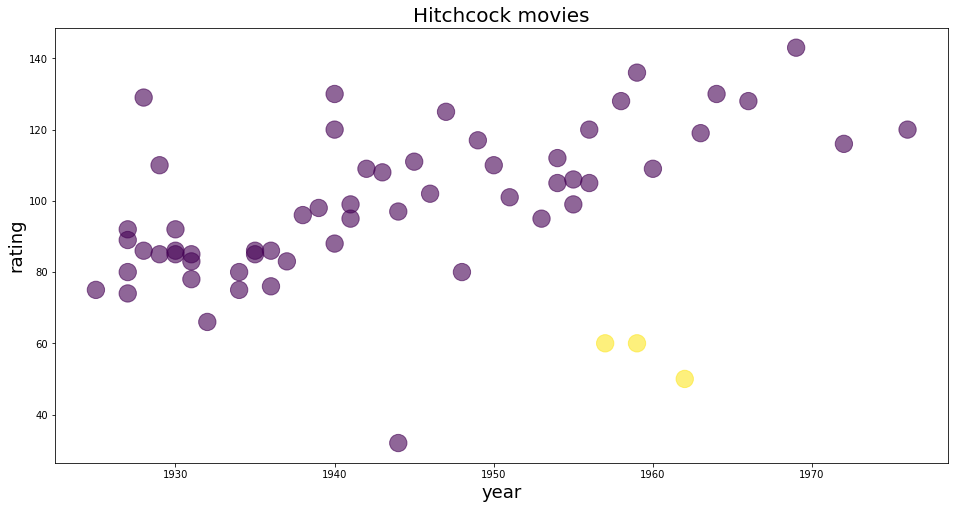

In [348]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))

In [355]:
x_label = 'year'
y_label = 'duration'
x_ = films_and_features_to_analyze_df[x_label]
y_ = films_and_features_to_analyze_df[y_label]

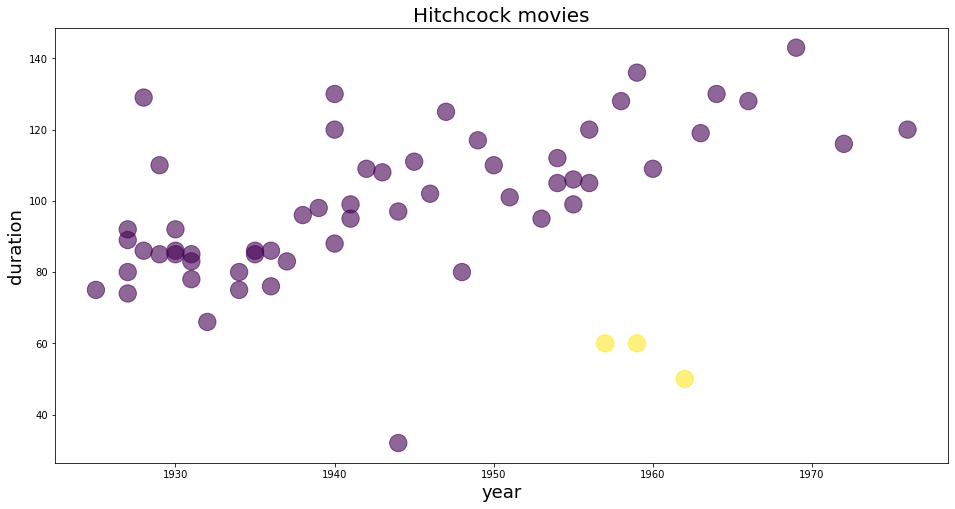

In [356]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))

In [357]:
x_label = 'year'
y_label = 'rating_count'
x_ = films_and_features_to_analyze_df[x_label]
y_ = films_and_features_to_analyze_df[y_label]

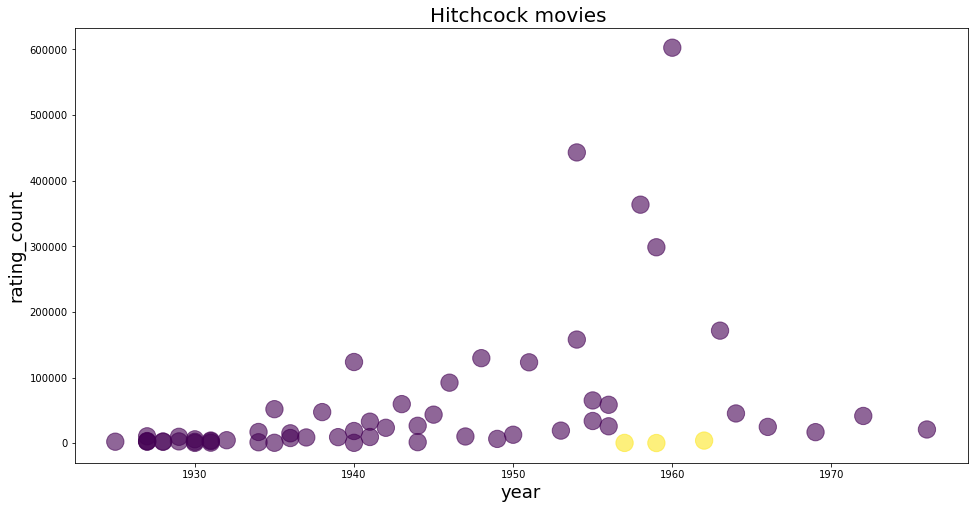

In [358]:
plt.figure(figsize=(16,8))
size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies ', fontsize='20')
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))


In [314]:
print( min(x_), max(x_))

1925.0 1976.0


In [315]:
from scipy import signal
signal.unit_impulse(1960) # come back to this to attempt to model "dirac impulse response" 
# for rating count based on year

array([1., 0., 0., ..., 0., 0., 0.])

In [322]:
films_and_features_to_analyze_df[films_and_features_to_analyze_df['duration'] <65]

,title,year,duration,cinematographer,documentary,tv_series,rating,rating_count,Edmund Gwenn,Gordon Harker,...,Edward Chapman,Basil Radford,George Curzon,Leslie Banks,Anny Ondra,Alfred Hitchcock,Grace Kelly,Malcolm Keen,Ian Hunter,Clare Greet
8,The Alfred Hitchcock Hour,1962.0,50.0,John F. Warren,0.0,1.0,8.5,3876.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11,Startime,1959.0,60.0,John L. Russell,0.0,1.0,5.6,127.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,Suspicion,1957.0,60.0,Ray Rennahan,0.0,1.0,8.4,320.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,Aventure malgache,1944.0,32.0,Günther Krampf,0.0,0.0,5.5,1446.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Breakdown by **cinematographers** Jack E. Cox, Robert Burks, and Bernard Knowles 

In [335]:
cinematographer = 'Jack E. Cox'

In [336]:
ctgrphr_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']==cinematographer]
other_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']!=cinematographer]


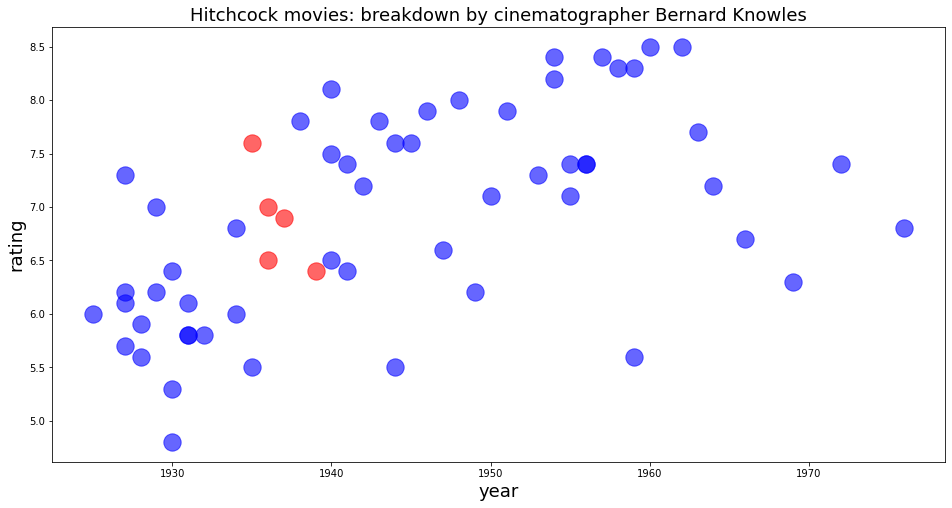

In [352]:
x_label = 'year'
y_label = 'rating'

x_cox = ctgrphr_flix[x_label]
y_cox = ctgrphr_flix[y_label]
x_non_cox = other_flix[x_label]
y_non_cox = other_flix[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies: Breakdown by cinematographer ' + cinematographer, fontsize='18')

category = 'tv_series'
plt.scatter(x=x_cox, y=y_cox, marker='o', alpha=alpha_, c = 'r', s=(size_,))
plt.scatter(x=x_non_cox, y=y_non_cox, marker='o', alpha=alpha_, c = 'b', s=(size_,))

plt.show()

In [340]:
cinematographer = 'Robert Burks'

In [341]:

ctgrphr_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']==cinematographer]
other_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']!=cinematographer]


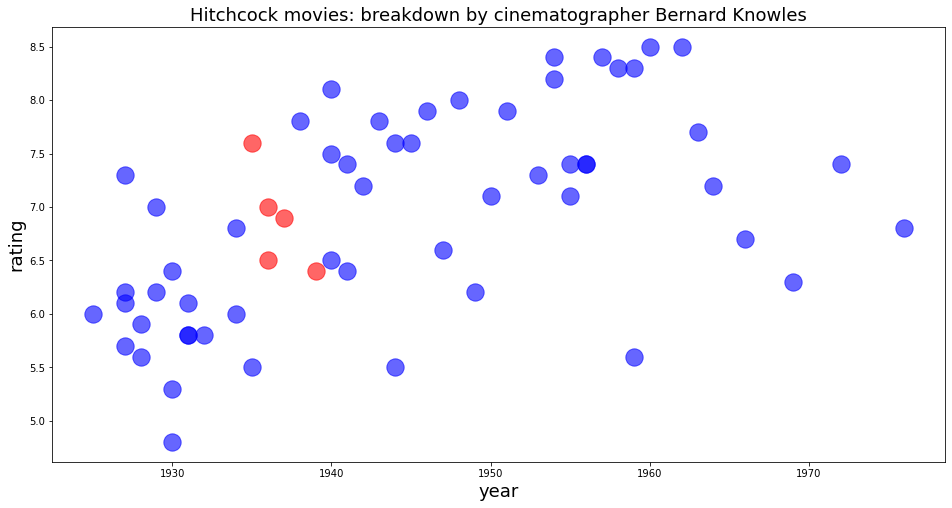

In [353]:
x_label = 'year'
y_label = 'rating'

x_cox = ctgrphr_flix[x_label]
y_cox = ctgrphr_flix[y_label]
x_non_cox = other_flix[x_label]
y_non_cox = other_flix[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies: Breakdown by cinematographer ' + cinematographer, fontsize='18')

category = 'tv_series'
plt.scatter(x=x_cox, y=y_cox, marker='o', alpha=alpha_, c = 'r', s=(size_,))
plt.scatter(x=x_non_cox, y=y_non_cox, marker='o', alpha=alpha_, c = 'b', s=(size_,))

plt.show()

In [343]:
cinematographer = 'Bernard Knowles'

In [344]:

ctgrphr_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']==cinematographer]
other_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']!=cinematographer]


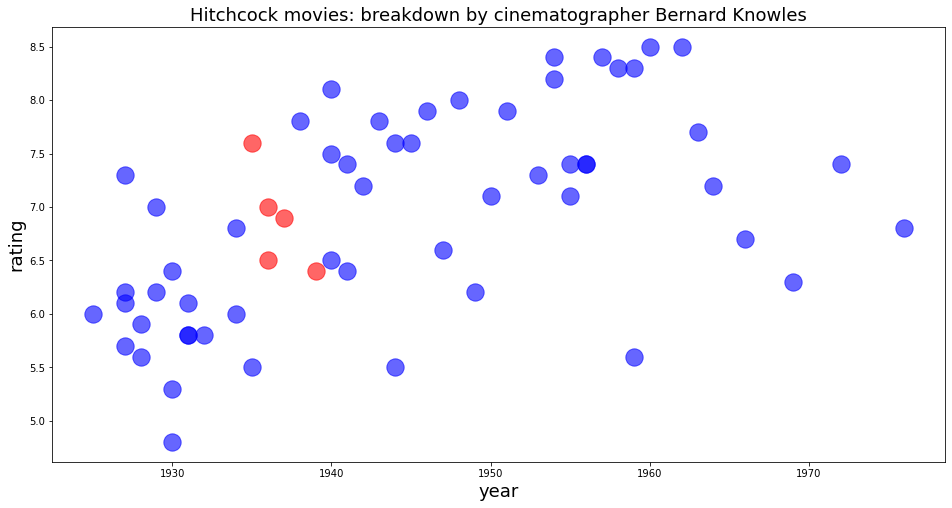

In [354]:
x_label = 'year'
y_label = 'rating'

x_cox = ctgrphr_flix[x_label]
y_cox = ctgrphr_flix[y_label]
x_non_cox = other_flix[x_label]
y_non_cox = other_flix[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies: ' + 'Breakdown by cinematographer ' + cinematographer, fontsize='18')

category = 'tv_series'
plt.scatter(x=x_cox, y=y_cox, marker='o', alpha=alpha_, c = 'r', s=(size_,))
plt.scatter(x=x_non_cox, y=y_non_cox, marker='o', alpha=alpha_, c = 'b', s=(size_,))

plt.show()

### Repartition data set to analyze `worldwide_gross`

In [ ]:
films_df_reordered

In [361]:
films_to_analyze_profits=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['worldwide_gross'].notnull()) & (films_df_reordered['worldwide_gross']!='') & (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]
#films_to_analyze_profits=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['rating'].notnull()) & (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]

films_to_analyze_profits.iloc[:,8:15]
films_to_analyze_profits

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Brigitte Auber,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger
2,Family Plot,1976.0,9 April 1976 (USA),120.0,120.0,4490375.0,13200000.0,NaN,13200000.0,6.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Frenzy,1972.0,21 June 1972 (USA),116.0,116.0,2000000.0,12600000.0,4121.0,12600000.0,7.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Topaz,1969.0,19 December 1969 (USA),143.0,143.0,4000000.0,6000000.0,NaN,6000000.0,6.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Torn Curtain,1966.0,27 July 1966 (USA),128.0,128.0,6000000.0,13000000.0,NaN,13000000.0,6.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Marnie,1964.0,17 July 1964 (USA),130.0,130.0,3000000.0,7008058.0,7095.0,7008058.0,7.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,The Birds,1963.0,29 March 1963 (USA),119.0,119.0,2500000.0,11436184.0,32655.0,11436184.0,7.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,Psycho,1960.0,8 September 1960 (USA),109.0,109.0,806947.0,32000000.0,32040242.0,32000000.0,8.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,North by Northwest,1959.0,18 December 1959 (USA),136.0,136.0,3101000.0,13369740.0,73695.0,13369740.0,8.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,Vertigo,1958.0,22 May 1958 (UK),128.0,128.0,2479000.0,3293831.0,7797300.0,3293831.0,8.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,Suspicion,1957.0,30 September 1957 (USA),60.0,60.0,NaN,4500000.0,NaN,4500000.0,8.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [362]:
new_analysis_columns = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', 'worldwide_gross', *selected_actor_columns]

In [363]:
films_and_features_to_analyze_profits = films_to_analyze_profits[new_analysis_columns]

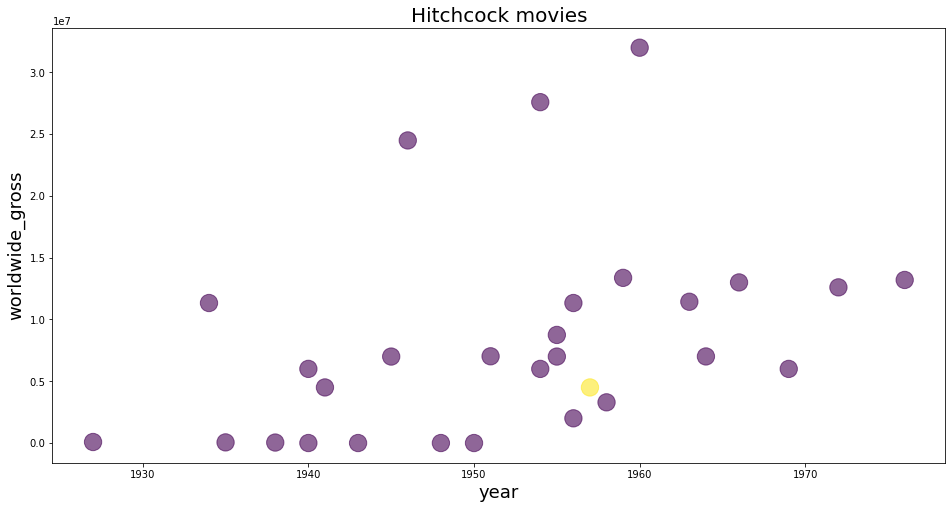

In [365]:
x_label = 'year'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

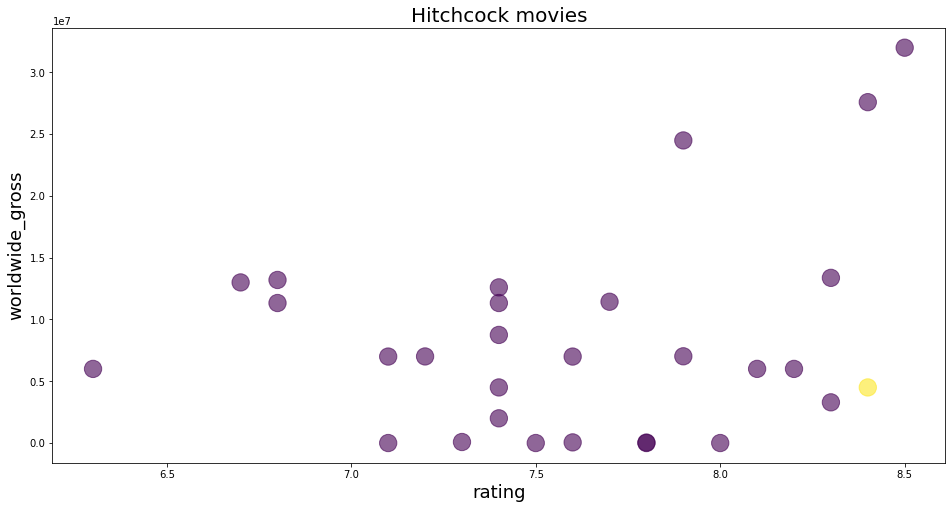

In [368]:
x_label = 'rating'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

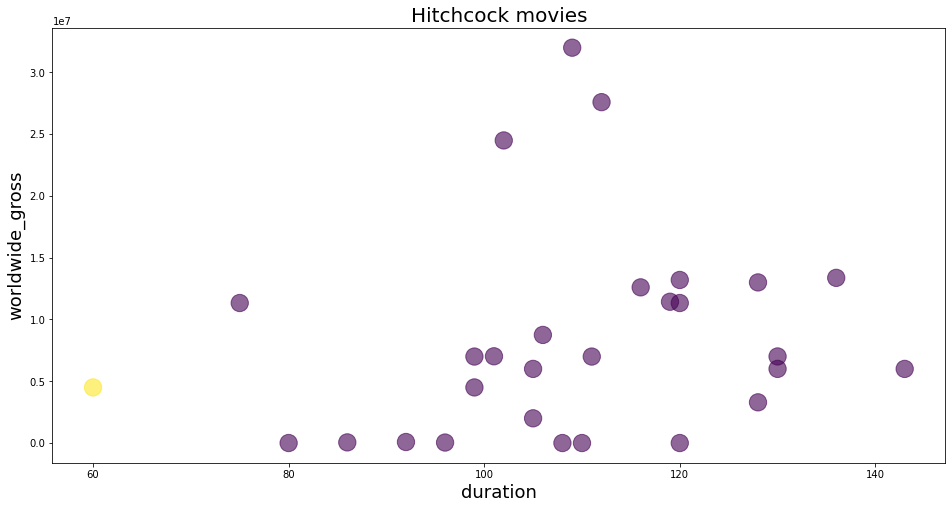

In [369]:
x_label = 'duration'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

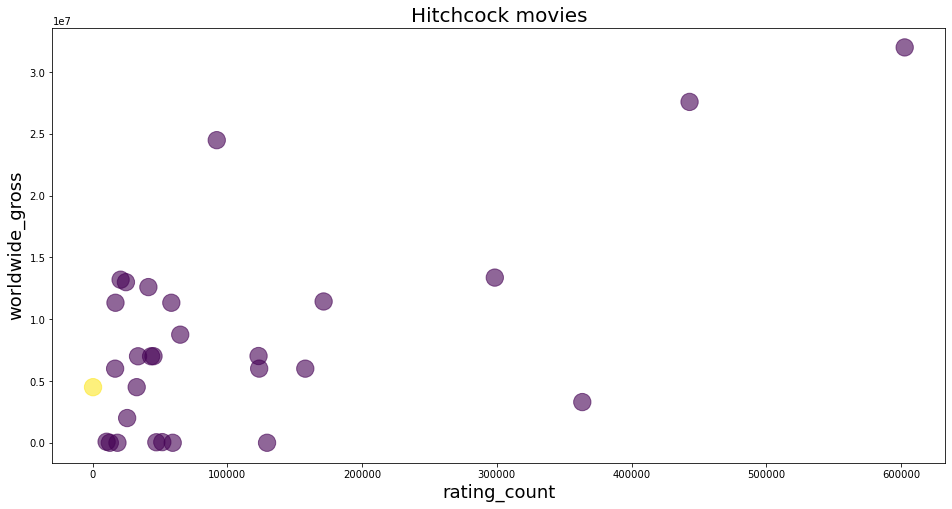

In [370]:
x_label = 'rating_count'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

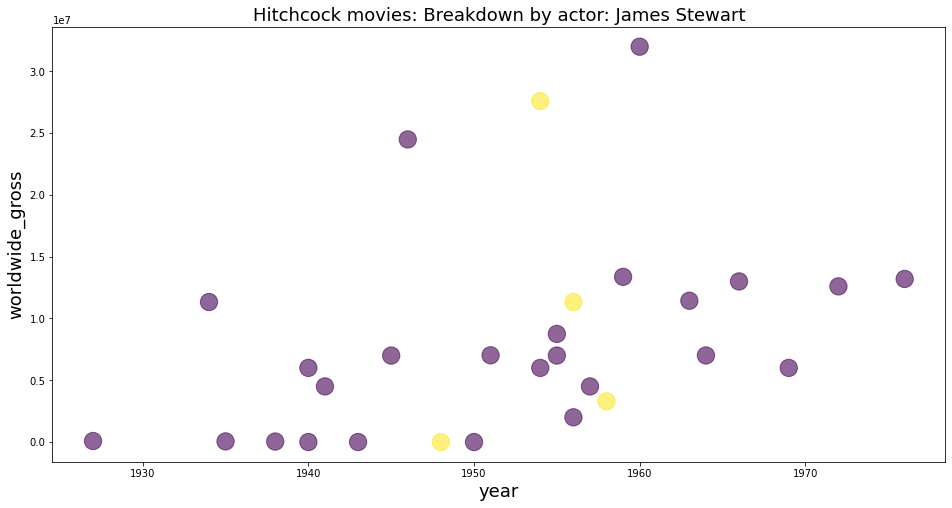

In [374]:
x_label = 'year'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'James Stewart'
plt.title(director.title() + ' movies: ' + 'Breakdown by actor: ' + category, fontsize='18')

plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

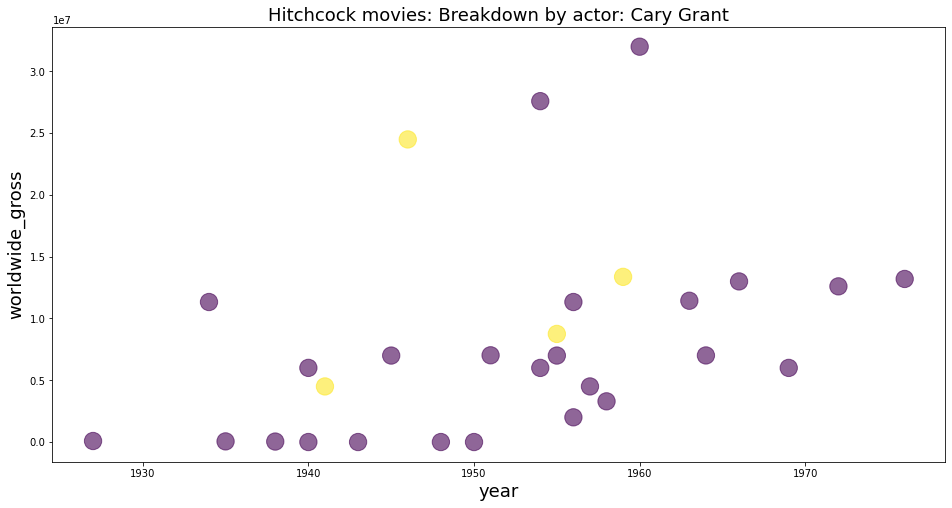

In [375]:
x_label = 'year'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'Cary Grant'
plt.title(director.title() + ' movies: ' + 'Breakdown by actor: ' + category, fontsize='18')

plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

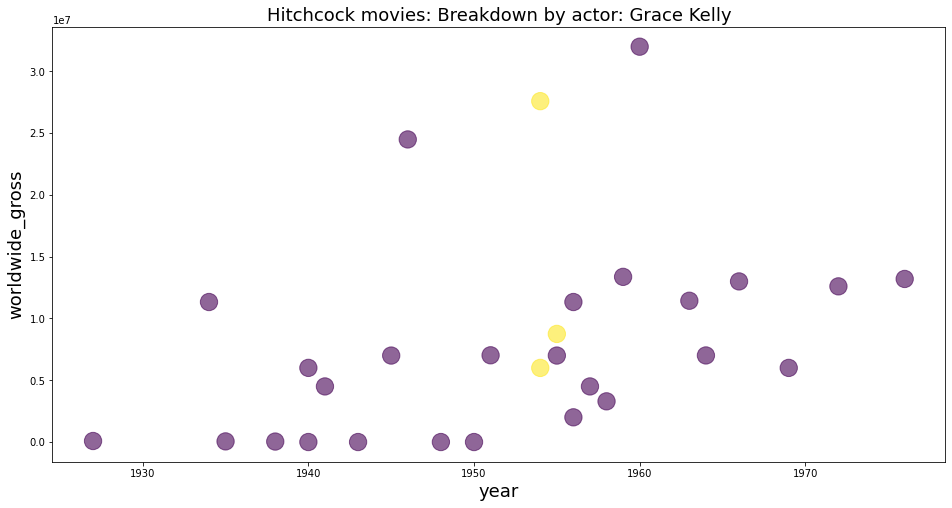

In [376]:
x_label = 'year'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'Grace Kelly'
plt.title(director.title() + ' movies: ' + 'Breakdown by actor: ' + category, fontsize='18')

plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

### Repartition data set to analyze `worldwide_gross` in terms of `budget` etc.

In [377]:

films_to_analyze_profits_and_budget=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['worldwide_gross'].notnull()) & (films_df_reordered['worldwide_gross']!='') & (films_df_reordered['budget'].notnull()) & (films_df_reordered['budget']!='')& (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]

films_to_analyze_profits_and_budget.iloc[:,8:15]
films_to_analyze_profits_and_budget


,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Brigitte Auber,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger
2,Family Plot,1976.0,9 April 1976 (USA),120.0,120.0,4490375.0,13200000.0,NaN,13200000.0,6.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Frenzy,1972.0,21 June 1972 (USA),116.0,116.0,2000000.0,12600000.0,4121.0,12600000.0,7.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Topaz,1969.0,19 December 1969 (USA),143.0,143.0,4000000.0,6000000.0,NaN,6000000.0,6.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Torn Curtain,1966.0,27 July 1966 (USA),128.0,128.0,6000000.0,13000000.0,NaN,13000000.0,6.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Marnie,1964.0,17 July 1964 (USA),130.0,130.0,3000000.0,7008058.0,7095.0,7008058.0,7.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,The Birds,1963.0,29 March 1963 (USA),119.0,119.0,2500000.0,11436184.0,32655.0,11436184.0,7.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,Psycho,1960.0,8 September 1960 (USA),109.0,109.0,806947.0,32000000.0,32040242.0,32000000.0,8.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,North by Northwest,1959.0,18 December 1959 (USA),136.0,136.0,3101000.0,13369740.0,73695.0,13369740.0,8.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,Vertigo,1958.0,22 May 1958 (UK),128.0,128.0,2479000.0,3293831.0,7797300.0,3293831.0,8.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,Suspicion,1941.0,14 November 1941 (USA),99.0,99.0,1103000.0,4500000.0,NaN,4500000.0,7.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [379]:
new_analysis_columns_budget = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', 'budget', 'worldwide_gross', *selected_actor_columns]

In [380]:
films_and_features_to_analyze_profits_and_budget = films_to_analyze_profits_and_budget[new_analysis_columns_budget]

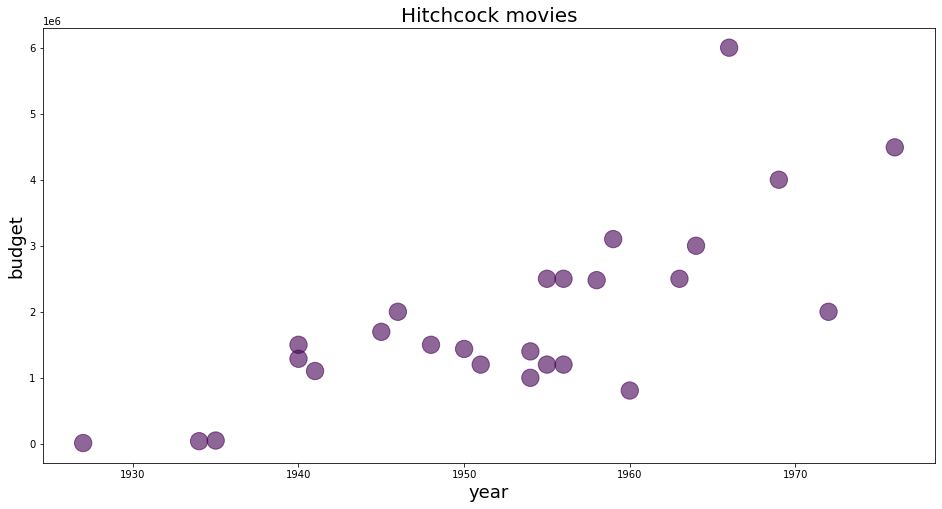

In [382]:
x_label = 'year'
y_label = 'budget'
x_ = films_and_features_to_analyze_profits_and_budget[x_label]
y_ = films_and_features_to_analyze_profits_and_budget[y_label]

plt.figure(figsize=(16,8))
plt.title(director.title() + ' movies', fontsize='20')

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits_and_budget[category], s=(size_,))

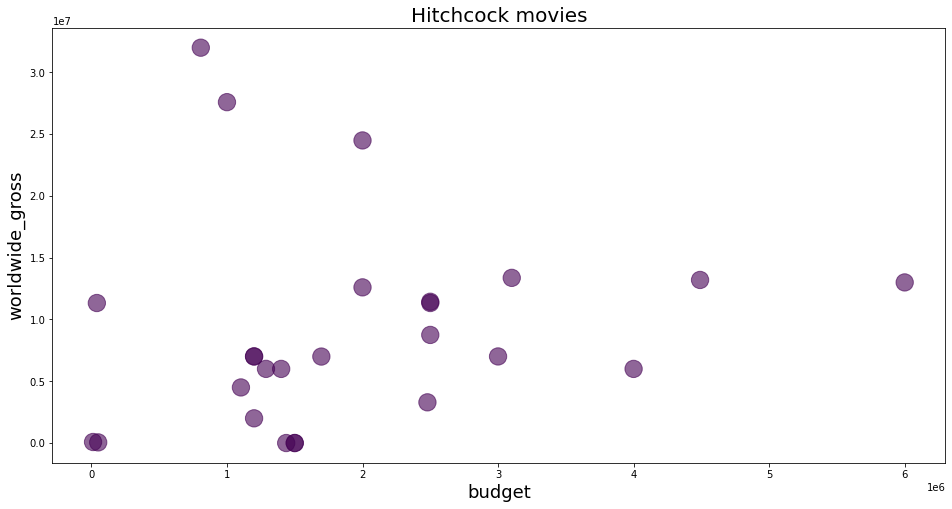

In [383]:
x_label = 'budget'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits_and_budget[x_label]
y_ = films_and_features_to_analyze_profits_and_budget[y_label]

plt.figure(figsize=(16,8))
plt.title(director.title() + ' movies', fontsize='20')

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits_and_budget[category], s=(size_,))

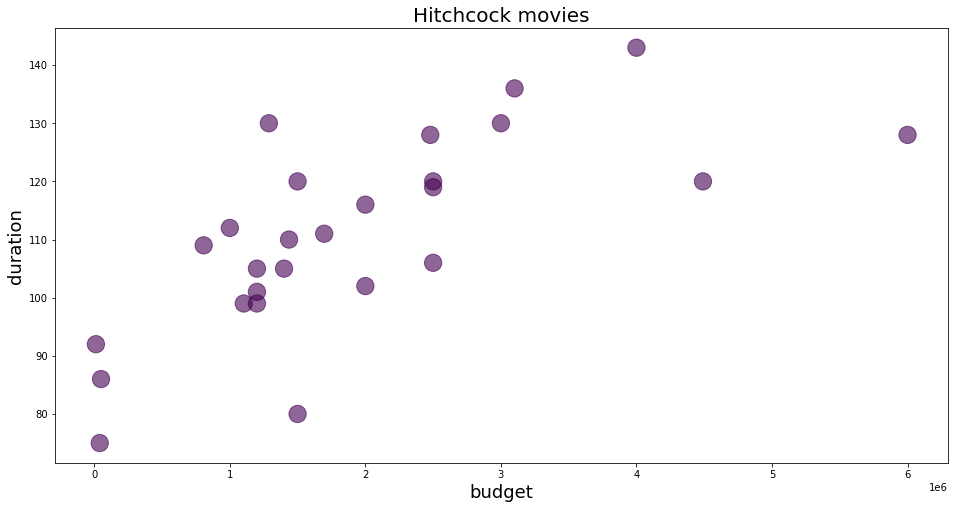

In [384]:
x_label = 'budget'
y_label = 'duration'
x_ = films_and_features_to_analyze_profits_and_budget[x_label]
y_ = films_and_features_to_analyze_profits_and_budget[y_label]

plt.figure(figsize=(16,8))
plt.title(director.title() + ' movies', fontsize='20')

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits_and_budget[category], s=(size_,))

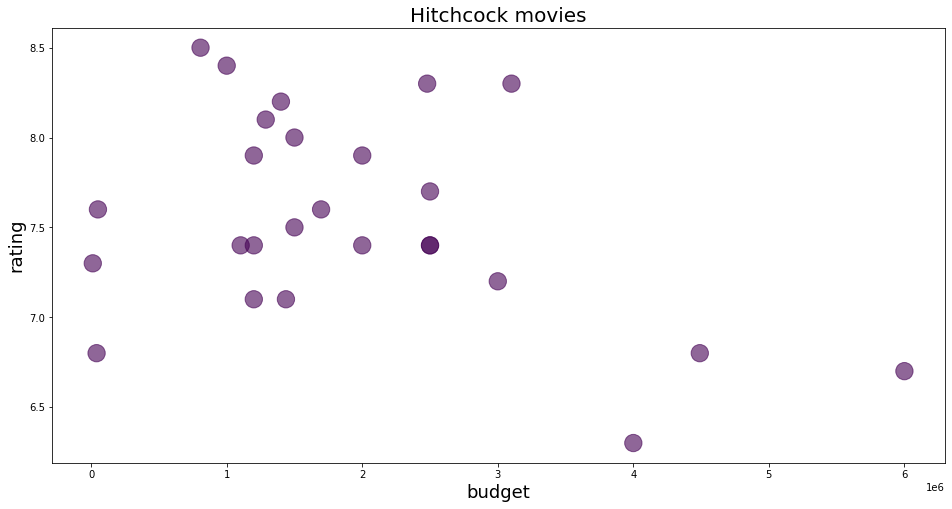

In [385]:
x_label = 'budget'
y_label = 'rating'
x_ = films_and_features_to_analyze_profits_and_budget[x_label]
y_ = films_and_features_to_analyze_profits_and_budget[y_label]

plt.figure(figsize=(16,8))
plt.title(director.title() + ' movies', fontsize='20')

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits_and_budget[category], s=(size_,))

In [ ]:
test_df = pd.DataFrame(
    list([[1, 2, 3], [4, np.nan, '2 October 1955 (USA', ], [7, 8, 9], [3, np.nan, '20 September 1962 (USA' ], [5, np.nan, '20 September 1962 (USA' ]]), 
    columns=['a', 'year', 'release_date']
)


In [ ]:
test_df['year'] = test_df.apply(
#     lambda row: re(r'\d{4}', row['release_date']) if np.isnan(row['year']) else row['year'],
#     axis=1)
    lambda row: float((re.search(r'\d{4}', row['release_date'])).group()) if np.isnan(row['year']) else row['year'],
    axis=1)
test_df

In [ ]:
row_release_date = '2 October 1955 (USA'
t = re(r'\d{4}', row_release_date).group()

In [ ]:
#films_df_reordered.apply( lambda row: row['year'] = re.search(r'\d{4}',  row['release_date'] ).group() if (row['year'].isnull() , axis=1)

In [ ]:
#match = re.match(r'\d{4}',  'julu 23 2947 sdkfj')


In [ ]:
release_date='julu 2329 sdkfj'
s = re.search(r'\d{4}',  release_date).group()
print(s)

In [ ]:
#films_df_reordered.loc[:,'year']=films_df_reordered['year'].apply(lambda year_data : (re.search(r'\d{4}',  str(films_df_reordered['release_date'])).group()) if pd.isna(year_data) else year_data)

In [ ]:
films_df_reordered.head(50)

In [ ]:
#films_df_reordered[ pd.isna(films_df_reordered['year']) ]['year'] = re.search(r'\d{4}',  films_df_reordered['release_date']).group()

In [ ]:
films_df.columns[first_cast_column:-1]

In [ ]:
s=[3, 4, 5]
t = [1, 2, *s]
t

In [ ]:
first_column_of_cast = 13
number_of_appearances_cutoff = 3
cast_columns_mask = list( film_catalog.iloc[:,first_column_of_cast:].sum()>=number_of_appearances_cutoff )
#cast_columns_mask 

In [ ]:
#film_catalog.iloc[:,first_column_of_cast:].sum()>=3 

In [ ]:
keep_columns_mask = list(np.full(first_column_of_cast, True, dtype=bool))

In [ ]:
keep_columns_mask.extend( cast_columns_mask)
keep_columns_mask

In [ ]:
film_catalog_w_prevelant_actors = film_catalog.loc[:, keep_columns_mask].head(45)
film_catalog_w_prevelant_actors.shape

In [ ]:
film_catalog_w_prevelant_actors

In [ ]:
film_catalog_w_prevelant_actors.iloc[:, 13:].sum()

In [ ]:
film_catalog_w_prevelant_actors.iloc[:,13:].pipe(lambda film_catalog_w_prevelant_actors: film_catalog_w_prevelant_actors.loc[:, film_catalog_w_prevelant_actors.sum().sort_values(ascending=False).index])

In [ ]:
film_catalog_w_prevelant_actors.iloc[:,13:].pipe(lambda df: df.loc[:, df.sum().sort_values(ascending=False).index])

In [ ]:
(film_catalog.iloc[:,13:].sum().iteritems())

In [ ]:
film_catalog[film_catalog.sum()>=3]

In [ ]:
film_catalog.loc[:,film_catalog.sum()>=3]

In [ ]:
[not s>2 for s in film_catalog.iloc[:,13:].sum()].tolist()

In [ ]:
film_catalog.iloc[:,13:].drop([not s>2 for s in film_catalog.iloc[:,13:].sum()], inplace=True)

In [ ]:

film_catalog.iloc[:,13:].drop([col for col, val in film_catalog.iloc[:,13:].sum() < 3 ], axis=1, inplace=True)

In [ ]:
film_catalog.tail(35)

In [ ]:
film_catalog.dtypes

In [ ]:
sns.pairplot( film_catalog )

In [ ]:
def traverse(soup):
    found = False
    if soup.name is not None:
        dom_dictionary = {}
        dom_dictionary['name'] = soup.name
        if dom_dictionary['name'] == 'h1':
            print('\n')
            print(soup.text)
            print('\n')
            if not found:
                found_object = soup
                found = True
        dom_dictionary['children'] = [ traverse(child) for child in soup.children if child.name is not None]
        return dom_dictionary, found_object

#traverse(soup)

### Test one film at a time

In [ ]:
#%%script false
# # Test area
# film_url='https://www.imdb.com/title/tt0086153/'
film_url = 'https://www.imdb.com/title/tt0084654/'

film_response = requests.get(film_url)
if(film_response.status_code < 400):
    film_page = film_response.text
    film_soup = BeautifulSoup(film_page, "lxml")
#   if ( not is_TV_Series( film_soup) ):
    film = parse_film_data( film_soup )
    print(film)
